In [16]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [2]:
spark = SparkSession.builder.getOrCreate()

# The RDD

Similar to the data frame, but distributes unordered objects rather than records and columns. Think of it as a bag of elements with no order or relationship to one another.

Good to use when:
* Have an unordered collection of Python objects that can be pickled
* Unordered key,value pairs, like a Python dict

<div>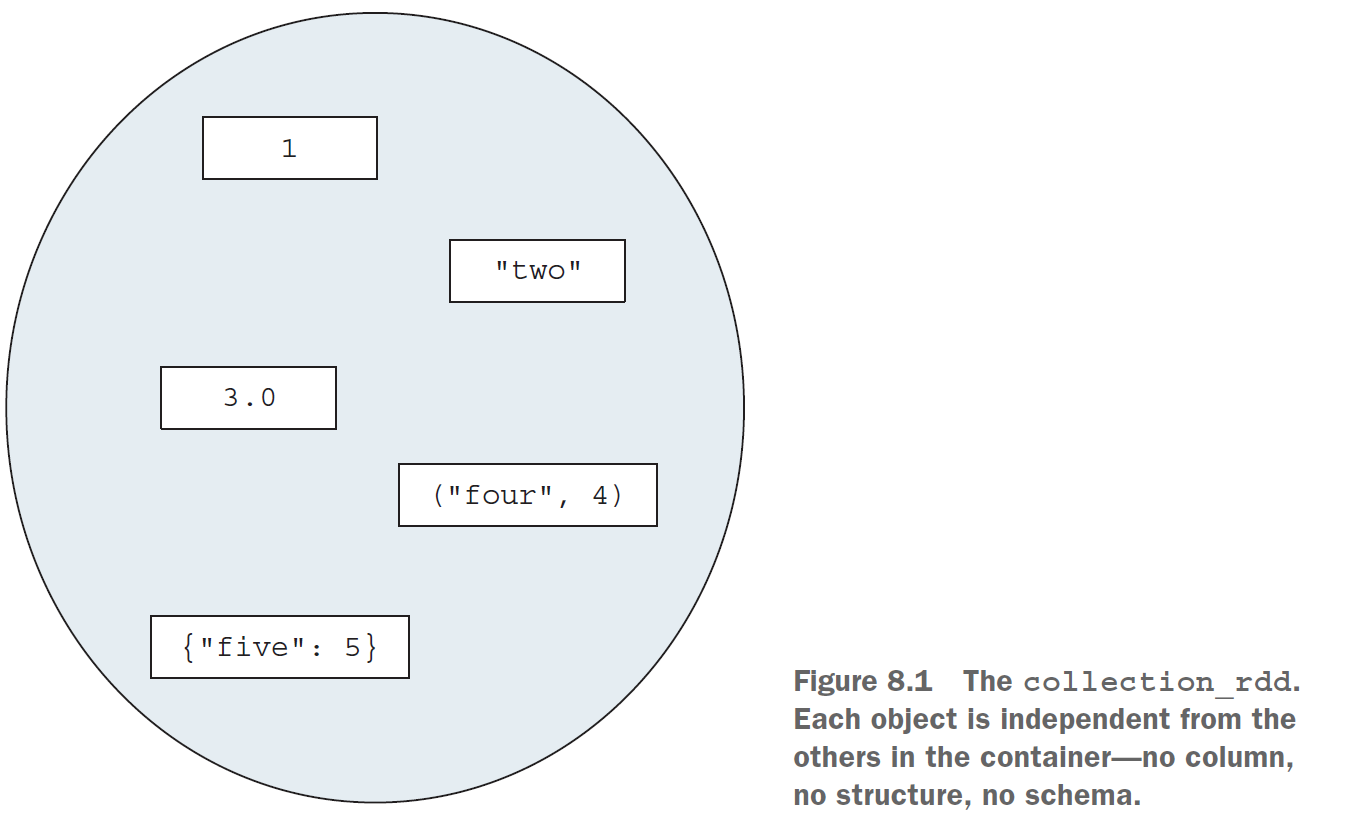</div>

It can ingest multiple data types into a single container abstraction

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

collection = [1, "two", 3.0, ("four", 4), {"five": 5}]

sc = spark.sparkContext

collection_rdd = sc.parallelize(collection)

print(collection_rdd)

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289


##  Manipulating data with RDD: map(), filter(), reduce()

map(), filter(), and reduce() all take a function (that we will call f) as their only parameter and return a copy of the RDD with the desired modifications. Wecall functions that take other functions as parameters higher-order functions.

The RDD is a lazy collection. If you have an error in your function application,
it will not be visible until you perform an action (e.g., collect()), just
like with the data frame.

### map()

Apply a function to every element of the RDD.

In [4]:
collection_rdd = sc.parallelize(collection)

def safer_add_one(value):
    try:
        return value + 1
    except TypeError:
        return value
    
collection_rdd = collection_rdd.map(safer_add_one)

print(collection_rdd.collect())

[2, 'two', 4.0, ('four', 4), {'five': 5}]


### filter()

The RDD differs from data frame because it takes a function f that is applied to every element, only then keeping the ones that return a truthful value.

In [5]:
collection_rdd = collection_rdd.filter(
    lambda elem: isinstance(elem, (float, int))
)

print(collection_rdd.collect())


[2, 4.0]


### reduce()

Two elements come in, one comes out. Summarization of data - similar to groupby()/agg().

In [6]:
from operator import add

collection_rdd = sc.parallelize([4, 7, 9, 1, 3])

print(collection_rdd.reduce(add))

24


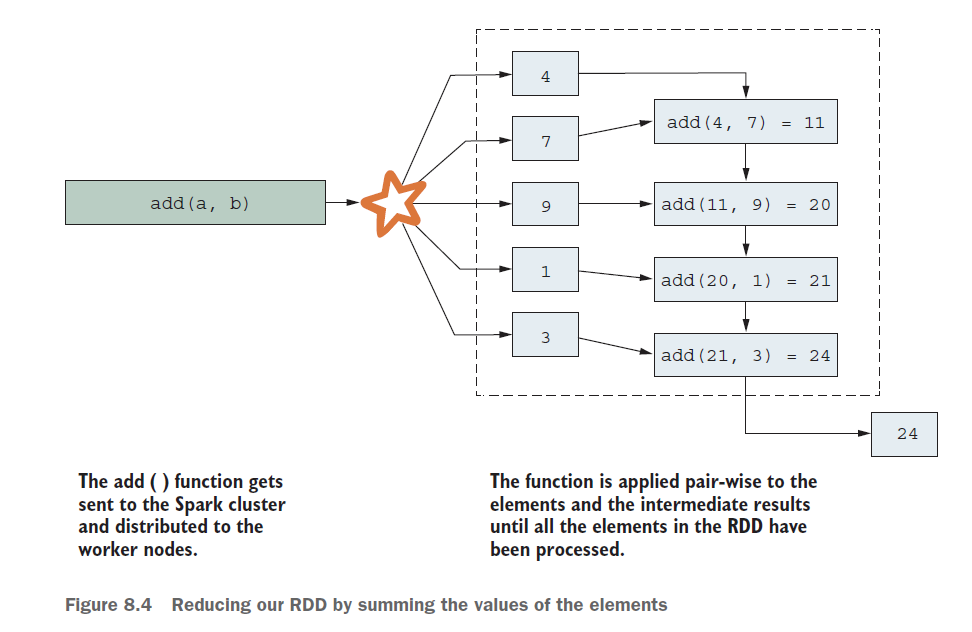

Regarding partitions, reduce() is first applied in each partition, and then each intermediate value is sent to the master node for the final reduction. Because of that, we need to implement associative and commutative functions.

associative: grouping does not matter: (a+b)+c = a+(b+c) 
 * add is associative, subtract for example is not!
 
commutative: order of arguments is not important: a+b = b+c 
 * again, add is commutative, subtract is not!
 
add(),multiply(), min() and max() are associative and commutative.

### Exercises

1. The PySpark RDD API provides a count() method that returns the number of elements
in the RDD as an integer. Reproduce the behavior of this method using map(),
filter(), and/or reduce().

In [7]:
collection_rdd = sc.parallelize(collection)

In [12]:
collection_rdd.map(lambda x: isinstance(x,int)).reduce(add)

1

#  UDF (User Defined Functions)

When creating an UDF:
 * Create and document the function.
 * Make sure the input and output types are compatible.
 * Test the function

In [13]:
from fractions import Fraction
from typing import Tuple, Optional

Frac = Tuple[int, int]

def py_reduce_fraction(frac: Frac) -> Optional[Frac]:
    """Reduce a fraction represented as a 2-tuple of integers."""
    num, denom = frac
    if denom:
        answer = Fraction(num, denom)
        return answer.numerator, answer.denominator
    return None

assert py_reduce_fraction((3, 6)) == (1, 2)
assert py_reduce_fraction((1, 0)) is None

def py_fraction_to_float(frac: Frac) -> Optional[float]:
    """Transforms a fraction represented as a 2-tuple of integers into a
    float."""
    num, denom = frac
    if denom:
        return num / denom
    return None

assert py_fraction_to_float((2, 8)) == 0.25
assert py_fraction_to_float((10, 0)) is None

udf() takes two parametrs: the function you want to promote, and the type of the generated UDF 

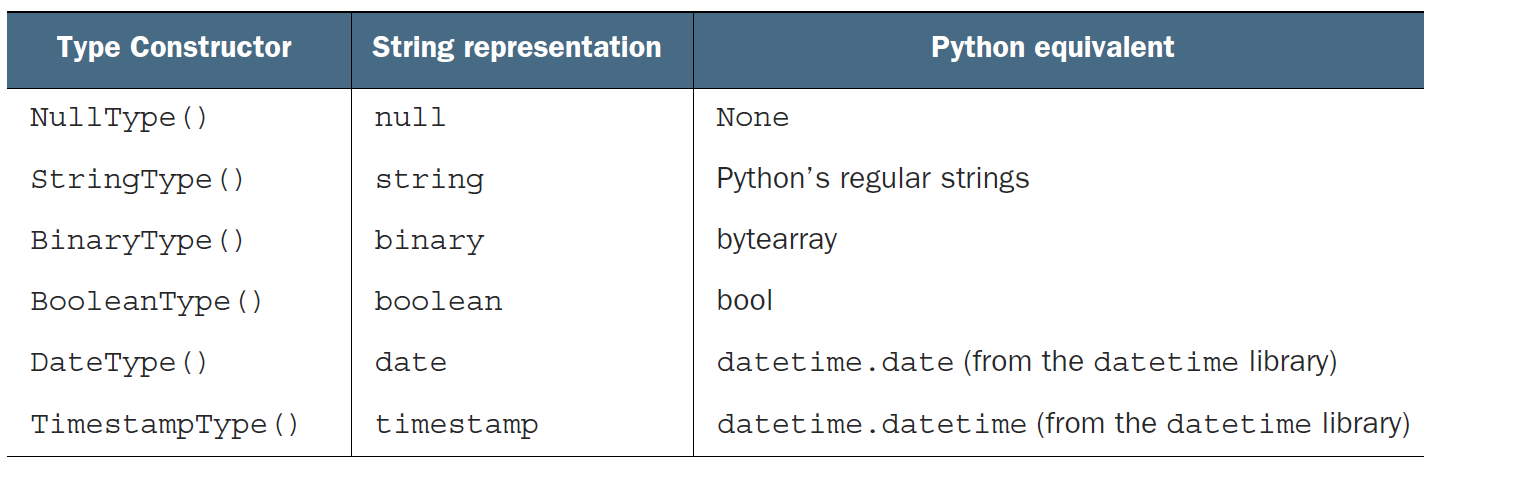
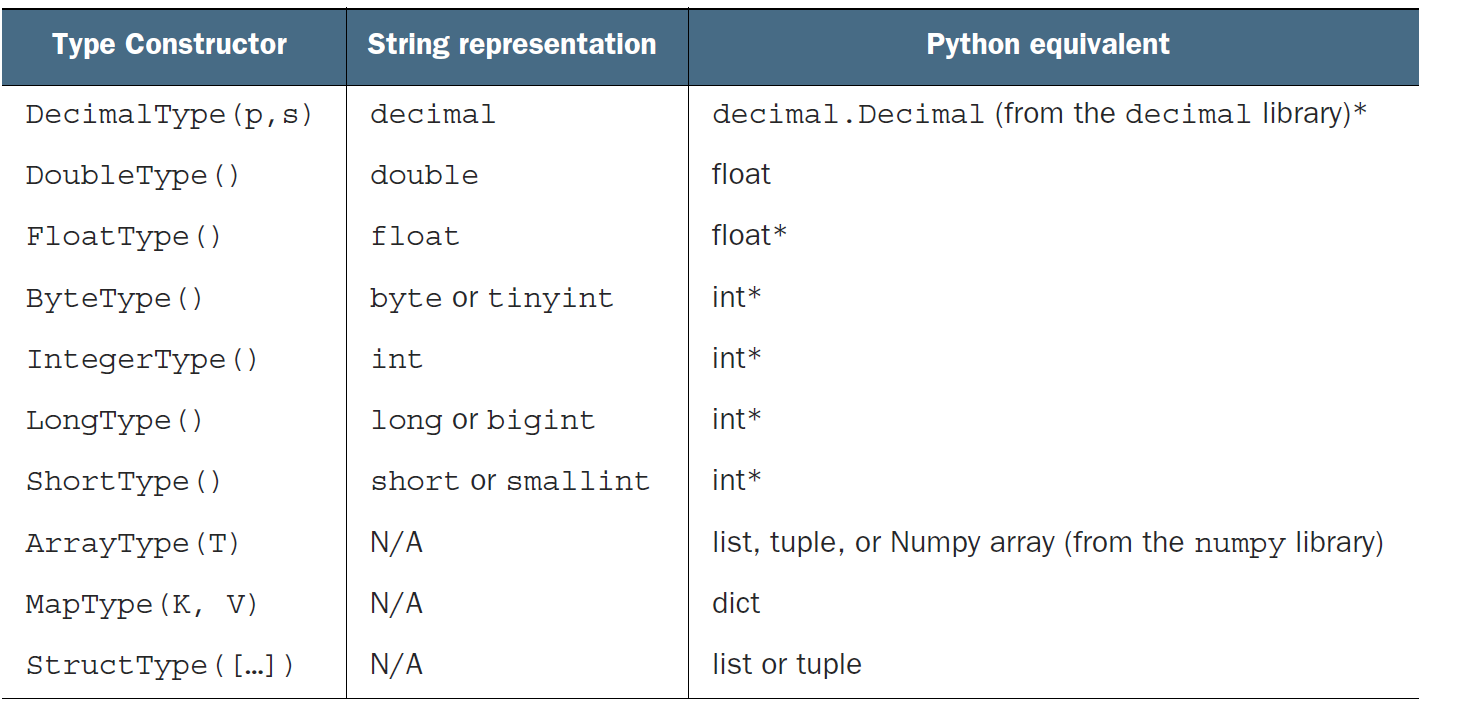
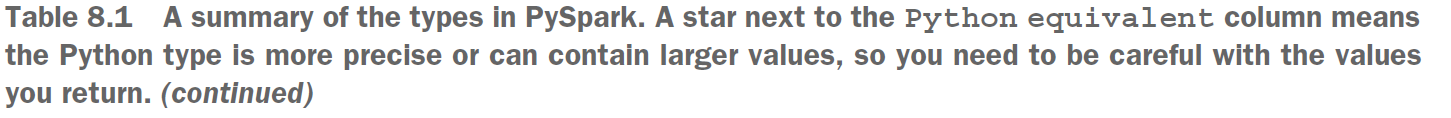

In [20]:
SparkFrac = T.ArrayType(T.LongType())

reduce_fraction = F.udf(py_reduce_fraction, SparkFrac)

fractions = [[x, y] for x in range(100) for y in range(1, 100)]

frac_df = spark.createDataFrame(fractions, ["numerator", "denominator"])    

frac_df = frac_df.select(
    F.array(F.col("numerator"), F.col("denominator")).alias(
        "fraction"
    ),
)

frac_df = frac_df.withColumn(
    "reduced_fraction", reduce_fraction(F.col("fraction"))
)
                        
frac_df.show(5, False)

+--------+----------------+
|fraction|reduced_fraction|
+--------+----------------+
|[0, 1]  |[0, 1]          |
|[0, 2]  |[0, 1]          |
|[0, 3]  |[0, 1]          |
|[0, 4]  |[0, 1]          |
|[0, 5]  |[0, 1]          |
+--------+----------------+
only showing top 5 rows



We can also use udf as decorator:

In [22]:
@F.udf(T.DoubleType())
def fraction_to_float(frac: Frac) -> Optional[float]:
    """Transforms a fraction represented as a 2-tuple of integers into a float."""
    num, denom = frac
    if denom:
        return num / denom
    return None

In [23]:
frac_df = frac_df.withColumn(
    "fraction_float", fraction_to_float(F.col("reduced_fraction"))
)

frac_df.select("reduced_fraction", "fraction_float").distinct().show(
    5, False
)

+----------------+-------------------+
|reduced_fraction|fraction_float     |
+----------------+-------------------+
|[3, 50]         |0.06               |
|[3, 67]         |0.04477611940298507|
|[7, 76]         |0.09210526315789473|
|[9, 23]         |0.391304347826087  |
|[9, 25]         |0.36               |
+----------------+-------------------+
only showing top 5 rows



In [25]:
assert fraction_to_float.func((1, 2)) == 0.5 ## calls the function within udf